# Alpha Sherpa Capital Exercise
PARK, Jung Jun David
### Library Version:
* pandas : 1.0.1
* numpy  : 1.19.5

In [1]:
# Importing Required Libraries
import pandas as pd
import matplotlib.pyplot as plt
import math as math
import numpy as np
import FinanceDataReader as fdr
from datetime import datetime, timedelta
from pandas import Timestamp

### Loading CSV file as DataFrame

In [2]:
raw_df = pd.read_csv('/Users/david/Documents/Intern-Sample-PNL-2Months.csv', header = 0, index_col = 0)

In [3]:
raw_df

,ATR,Reason,Side,ATR(x),ATR Used,Risk,Position,Position(R),Entry Price,STOP LOSS PRICE,...,Day 4 Date,Day 4 High,Day 4 low,Day 4 open,Day 4 close,Day 5 Date,Day 5 High,Day 5 low,Day 5 open,Day 5 close
Ticker,,,,,,,,,,,,,,,,,,,,,
TAN US Equity,5.01,AH+,long,1.0,5.01,2000.0,399.20,400.0,121.63,116.62,...,1/12/2021,117.72,113.45,117.22,115.63,1/13/2021,116.26,113.04,116.16,114.46
ARKK US Equity,4.83,reduce,long,2.0,9.66,2000.0,207.04,207.0,131.16,121.50,...,1/12/2021,141.66,139.04,140.18,140.99,1/13/2021,143.5,140.5,141.93,141.72
GBTC US Equity,0.86,HEDGE,long,1.5,1.29,2000.0,1552.19,1576.0,14.74,13.45,...,11/10/2020,17,16.24,16.94,16.51,11/11/2020,18,16.75,16.75,17.525
NIO US Equity,2.93,AH+,long,2.5,7.33,2000.0,273.04,273.0,51.29,43.97,...,1/7/2021,54.61,52.35,53.05,54.28,1/8/2021,59.31,55.88,57.76,58.92
QBTC CN Equity,2.52,reduced,long,1.0,2.52,9000.0,3571.43,2598.0,26.50,23.98,...,11/20/2020,29.6,27.99,28.19,29.49,11/23/2020,31,29.5,30.09,30.81
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Pre-processing Functions and Related Items

In [4]:
countries = ['Hong Kong','Switzerland', 'Germany', 'France','Italy','Netherlands', 'Spain','Finland',
             'Sweden','Denmark', 'Norway', 'London', 'Belgium','Austria','Portugal', 'Japan', 'USA', 'Canada']
dict_countries = {"HK Equity":'Hong Kong', "SW Equity":'Switzerland', "GY Equity":'Germany', "FP Equity":'France',
                  "IM Equity":'Italy',"NA Equity":'Netherlands', "SM Equity":'Spain',"FH Equity":'Finland',"SS Equity": 'Sweden',
                  "DC Equity":'Denmark', "NO Equity":'Norway', "LN Equity":'London',"BB Equity": 'Belgium', "AV Equity":'Austria',
                  "PL Equity":'Portugal', "JT Equity":'Japan', "US Equity":'USA', "CN Equity":'Canada'}
add_dict = {'HKD':'Hong Kong', 'EUR':'Europe','CHF':'Switzerland','SEK':'Sweden',
             'DKK':'Denmark','NOK':'Norway', 'GBp':'London', 'USD':'USA', 'CAD':'Canada'}

def clean_table_task1(df):
    df = df.rename(columns={'Unnamed: 17': 'Market'})
    df = df.dropna(how = 'all')
    df = df.dropna(subset = ['Risk'])
    return df

def convert2datetime(df):
    '''
        Columns 'Entry Date' and 'Exit Date' includes the time data.
        However, the data type is not consistent - consists of string and datetime data types
        This function converts string time data into datetime type
    '''
    columnList = df.columns.to_list()
    Day_2_date = df.columns.tolist().index('Day 2 Date')
    tgt_col_idxs = [ columnList.index(tgt_col) for tgt_col in ['Entry Date', 'Exit Date']]
    for tgt_idx in tgt_col_idxs:
        for row_idx in range(len(df)):
            checker = df.iat[row_idx, tgt_idx]
            df.iat[row_idx, tgt_idx] = parsing_date(checker)
            
    '''
        There are some errors with date inputs.
        Ex. When Entry Date: 2/1/2021 but Exit Date is 12/1/2021 for AG US Equity.
        Exit Date of 1/12/2021 would also not make sense as it is earlier than Entry Date
        Hence access Day 1 Date to confirm the Entry Date.
        If the Exit Date is still before the Entry Date, then assume Entry = Exit
    '''
    for r_idx in range(len(df)):
        if (df.iloc[r_idx, tgt_col_idxs[0]] > df.iloc[r_idx, tgt_col_idxs[1]]):
            df.iloc[r_idx, tgt_col_idxs[0]] = datetime.strptime(df.iloc[r_idx, Day_2_date],'%m/%d/%Y') - timedelta(days= 1)
            
            if (df.iloc[r_idx, tgt_col_idxs[0]] > df.iloc[r_idx, tgt_col_idxs[1]]):
                df.iloc[r_idx, tgt_col_idxs[1]] = df.iloc[r_idx, tgt_col_idxs[0]]   
    return df

def parsing_date(date_string):
    for date_format in ('%m/%d/%Y', '%d-%b','%b-%d','%m/%d','%d/%m'):
        try:
            if (date_format == '%m/%d/%Y'):
                target = datetime.strptime(date_string, date_format)
                if (target > datetime.strptime('03/01/2021','%m/%d/%Y')):
                    target = datetime.strptime(date_string, '%d/%m/%Y')
            
            elif (date_format == '%d-%b'):
                target = datetime.strptime(date_string, date_format)
                target = target.replace(year= 2021)
            
            elif (date_format == '%b-%d'):
                target = datetime.strptime(date_string, date_format)
                target = target.replace(year= 2021)
            
            elif (date_format == '%m/%d'):
                target = datetime.strptime(date_string, date_format)
                target = target.replace(year= 2021)
                if (target > datetime.strptime('03/01/2021', '%m/%d/%Y')):
                    target = datetime.strptime(date_string, '%d/%m')
                    target = target.replace(year= 2021)

            return target
        
        except ValueError:
            pass
    raise ValueError('no valid date format found')


def assign_country_code_by_ticker(df):
    market_col_idx = df.columns.tolist().index('Market')
    df.iloc[:, market_col_idx] = [v[-9:] for v in df['Ticker'].values]
    df['Market'] = df['Market'].map(dict_countries) ## fill Market column by using Ticker information and country data
    not_yet_filled_idx_list = [idx for idx, c in enumerate(df['Market']) if c not in countries]
    print("# of data is not yet filled - {} by ticker".format(len(not_yet_filled_idx_list)))
    return df, not_yet_filled_idx_list

def assign_country_code_by_currency(df, not_yet_filled_idx_list):    
    '''
        For ones that are not part of the dictionary, I assign their country code based on their Currency
        For Euro, I arbitarily assigned Europe
    '''
    market_col_idx = df.columns.tolist().index('Market')
    df.iloc[not_yet_filled_idx_list, market_col_idx] = df['Curncy'][not_yet_filled_idx_list].map(add_dict)
    not_yet_filled_idx_list = [idx for idx, c in enumerate(df['Market']) if c not in countries]
    print("# of data not yet filled - {}".format(len(not_yet_filled_idx_list)))
    return df, not_yet_filled_idx_list


In [5]:
PnL = clean_table_task1(raw_df)
PnL = convert2datetime(PnL)
PnL = PnL[PnL.columns[0:17]]
PnL = PnL.reset_index() ## extract index as a column 'Ticker'
market_col_idx = PnL.columns.tolist().index('Market')
PnL, not_yet_filled_idx_list = assign_country_code_by_ticker(PnL)
PnL, not_yet_filled_idx_list = assign_country_code_by_currency(PnL, not_yet_filled_idx_list)
print(PnL.iloc[not_yet_filled_idx_list, market_col_idx])
# Assigned Europe for those as printed


# of data is not yet filled - 9 by ticker
# of data not yet filled - 3
138    Europe
221    Europe
229    Europe
Name: Market, dtype: object


# P&L Analysis
## Descriptive Analysis
### By Market

Market
Belgium           6525.46
Canada          116634.94
Denmark         -37927.26
Europe          -11715.00
Finland          -1870.69
France            6356.92
Germany          12388.21
Hong Kong        39770.91
Italy             -109.44
London        -1321144.42
Netherlands       2326.67
Norway          -40035.04
Portugal          -839.88
Spain              939.82
Sweden          -29268.70
Switzerland       2515.51
USA              32552.09
Name: Realized gains, dtype: float64


Text(0, 0.5, 'Profit/Loss in Respective Currency')

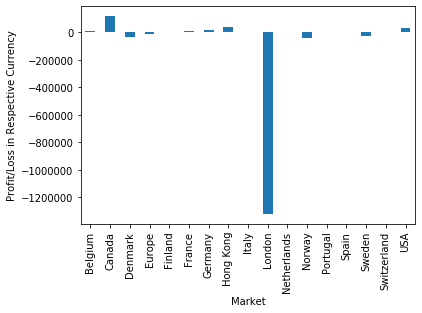

In [6]:
Market = PnL.groupby('Market').sum()
print(Market['Realized gains'])
Market['Realized gains'].plot.bar()
plt.ylabel('Profit/Loss in Respective Currency')

### By Currency

Curncy
CAD     116634.94
CHF       2515.51
DKK     -37927.26
EUR      14002.07
GBp   -1321144.42
HKD      39770.91
NOK     -40035.04
SEK     -29268.70
USD      32552.09
Name: Realized gains, dtype: float64


Text(0, 0.5, 'Profit/Loss By Currency')

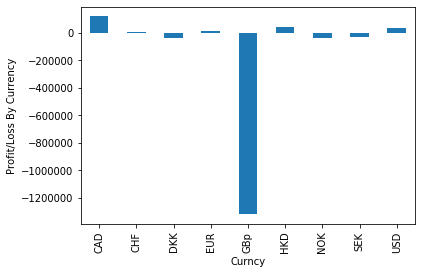

In [7]:
currency = PnL.groupby('Curncy').sum()
print(currency['Realized gains'])
currency['Realized gains'].plot.bar()
plt.ylabel('Profit/Loss By Currency')

* Apparent that the trades that occured on the London Exchange showed weak performances
* Will conduct further analysis on trades that occured on the London Exchange later

### Integrate Currency: Keep the Currency
Assume that you would keep the foreign currency for future trading purposes <br>
Convert the Realized Gains in Currency of choice, quoted in today's FX rate. <br>
* Note that this function is valid for Weekday usage (FX market is closed on weekends)
* There is another function below that converts the gains with the FX rate as of Exit Date

In [8]:
def currency_today(df, base_currency):
    curr_list = list(df.groupby('Curncy').groups.keys())
    if base_currency in curr_list: curr_list.remove(base_currency)
    fx_rate= []
    for currency in curr_list:
        fx_rate.append(fdr.DataReader(currency+'/'+ base_currency, '2021-03-12')['Close'])
        
    return fx_rate

calculate_currency = 'USD'
fx_rate_today = currency_today(PnL,calculate_currency)

In [9]:
profit_per_currency = currency['Realized gains']
integrated_profit = 0
j = 0
for i in range(len(profit_per_currency.index)):
    if (profit_per_currency.index[i] == calculate_currency):
        continue
    else:
        integrated_profit += profit_per_currency[i] * fx_rate_today[j]
        j += 1

print("Profit of ",round(integrated_profit[0]),calculate_currency," in the last two months with today's FX rate")

Profit of  -1735538 USD  in the last two months with today's FX rate


### Integrate Currency: Change the Currency
Convert the Realized Gains in Currency of choice, quoted in Exit Date's FX rate.
* Note that it takes some time to run this. About 2 minutes.

In [10]:
def currency_exit_date(df, base_currency):
    gain_exit = 0
    curr_col_idx = df.columns.get_loc('Curncy')
    exit_col_idx = df.columns.get_loc('Exit Date')
    gain_col_idx = df.columns.get_loc('Realized gains')
    for i in range(len(df)):
        tgt_curr = df.iloc[i,curr_col_idx]
        tgt_date = df.iloc[i,exit_col_idx]
        tgt_gain = df.iloc[i,gain_col_idx]
        if (tgt_curr == base_currency):
            gain_exit += tgt_gain
        else:
            fx_rate_exit = fdr.DataReader(tgt_curr + '/' + base_currency, tgt_date, tgt_date)['Close']
            gain_exit += (tgt_gain * fx_rate_exit)[0]
    return gain_exit

calculate_currency = 'USD'
print("Profit of ",round(currency_exit_date(PnL, calculate_currency)),calculate_currency," in the last two months with Exit Date's FX rate")

Profit of  -1652154 USD  in the last two months with Exit Date's FX rate


### Analysis in terms of Long/Short

# of Long/Short Strategies Executed
Side
long     256
short    139
Name: Realized gains, dtype: int64


Text(0.5, 1.0, '# of Long & Short')

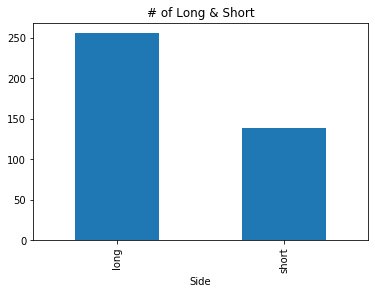

In [11]:
long_short = PnL.groupby('Side')['Realized gains']
print("# of Long/Short Strategies Executed")
print(long_short.size())
long_short.size().plot.bar()
plt.title("# of Long & Short")

In [138]:
hit_long = long_short.apply(lambda x: x[x > 0].count())[0]/long_short.count()[0]
hit_short = long_short.apply(lambda x: x[x > 0].count())[1]/long_short.count()[1]

print("Hit rate when executing a long strategy is ", hit_long)
print("Hit rate when executing a short strategy is ", hit_short)
print('From this, it is evident that the short strategy has been more successful recently')

Hit rate when executing a long strategy is  0.4453125
Hit rate when executing a short strategy is  0.4748201438848921
From this, it is evident that the short strategy has been more successful recently


# of Long/Short Strategies per Market
Market       Side 
Belgium      short     3
Canada       long      8
             short     2
Denmark      long      3
             short     4
Europe       short     3
Finland      short     1
France       long     13
             short     4
Germany      long     32
             short    14
Hong Kong    long     61
             short    24
Italy        long      6
London       long     12
             short     3
Netherlands  long      5
             short     1
Norway       long      3
Portugal     long      1
Spain        long      5
             short     1
Sweden       long      4
Switzerland  long     13
             short     3
USA          long     90
             short    76
Name: Realized gains, dtype: int64


Text(0, 0.5, '# of Trades')

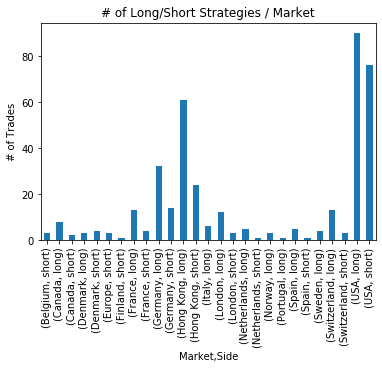

In [13]:
perf_by_market = PnL.groupby(['Market','Side'])['Realized gains']
print("# of Long/Short Strategies per Market")
print(perf_by_market.count())
perf_by_market.count().plot.bar()
plt.title('# of Long/Short Strategies / Market')
plt.ylabel('# of Trades')

In [14]:
hit_by_market_ls = perf_by_market.apply(lambda x: x[x>0].count()) / perf_by_market.count()
print("Hit Rate of Long/Short Strategies per Market")
print(hit_by_market_ls)

Hit Rate of Long/Short Strategies per Market
Market       Side 
Belgium      short    1.000000
Canada       long     0.625000
             short    1.000000
Denmark      long     0.000000
             short    0.500000
Europe       short    0.333333
Finland      short    0.000000
France       long     0.538462
             short    0.750000
Germany      long     0.593750
             short    0.428571
Hong Kong    long     0.409836
             short    0.416667
Italy        long     0.500000
London       long     0.250000
             short    0.333333
Netherlands  long     0.800000
             short    0.000000
Norway       long     0.333333
Portugal     long     0.000000
Spain        long     0.600000
             short    0.000000
Sweden       long     0.250000
Switzerland  long     0.538462
             short    0.333333
USA          long     0.400000
             short    0.486842
Name: Realized gains, dtype: float64


### Average Holding Period
* Non-trading days are not counted: Counted with Business Days

/Users/david/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/david/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


Market
Belgium         2.333333
Canada         15.700000
Denmark         2.142857
Europe          0.500000
Finland         0.000000
France          2.941176
Germany         3.934783
Hong Kong       2.253012
Italy           1.833333
London          1.533333
Netherlands     4.333333
Norway          3.000000
Portugal        2.000000
Spain           4.333333
Sweden          2.500000
Switzerland     1.437500
USA             5.271084
Name: Hold Period, dtype: float64


Text(0, 0.5, 'Holding Days')

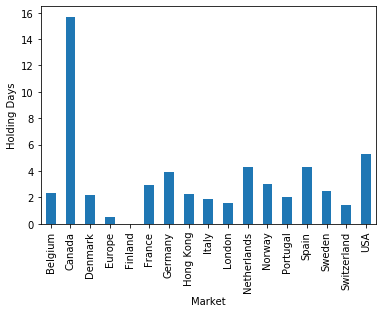

In [15]:
omit_PnL = PnL[~PnL.Ticker.str.contains("Index")]
omit_PnL.loc[:,'Hold Period'] = 0
for i in range(len(omit_PnL)):
    entry_date = omit_PnL.iloc[i,omit_PnL.columns.get_loc('Entry Date')].date()
    exit_date = omit_PnL.iloc[i,omit_PnL.columns.get_loc('Exit Date')].date()
    date_diff = np.busday_count(entry_date, exit_date)
    omit_PnL.iloc[i,omit_PnL.columns.get_loc('Hold Period')] = date_diff

hold_period = omit_PnL.groupby('Market')['Hold Period'].sum() / omit_PnL.groupby('Market')['Hold Period'].count()
print(hold_period)
hold_period.plot.bar()
plt.ylabel('Holding Days')

### Realized R

Text(0.5, 1.0, 'Realized R by Market')

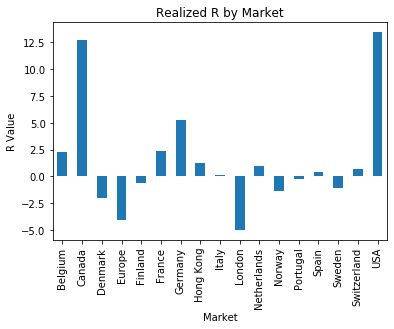

In [140]:
r_per_market = PnL.groupby('Market')['Realized R']
r_per_market.sum()
r_per_market.sum().plot.bar()
plt.ylabel('R Value')
plt.title('Realized R by Market')

The graph clearly shows that the best R performances were from the USA and Canada <br>
While the worst trades were in London and Europe

### Expectancy per Market

Market
Belgium         2175.153333
Canada         11663.494000
Denmark        -5418.180000
Europe         -3905.000000
Finland        -1870.690000
France           373.936471
Germany          269.308913
Hong Kong        337.863721
Italy            -18.240000
London        -88076.294667
Netherlands      387.778333
Norway        -13345.013333
Portugal        -839.880000
Spain            156.636667
Sweden         -7317.175000
Switzerland      157.219375
USA              196.096928
Name: Realized gains, dtype: float64


Text(0.5, 1.0, 'Expectancy / Market')

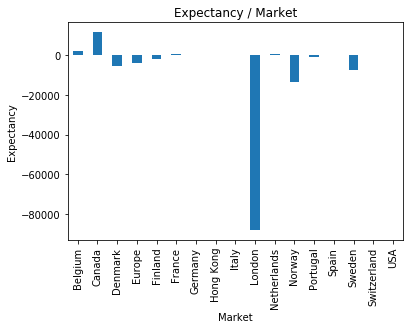

In [141]:
exp_per_market = PnL.groupby('Market')['Realized gains']
hit_by_market = exp_per_market.apply(lambda x: x[x>0].count()) / exp_per_market.count()
avg_win = exp_per_market.apply(lambda x: x[x>0].sum()) / exp_per_market.apply(lambda x: x[x>0].count())
# This part to prevent NaN that arises from 0 Win in certain regions such as Finland
for i in range(len(avg_win)):
    if (math.isnan(avg_win[i])):
        avg_win.iloc[i] = 0
        
avg_loss = exp_per_market.apply(lambda x: x[x<0].sum()) / exp_per_market.apply(lambda x: x[x<0].count())
for i in range(len(avg_loss)):
    if (math.isnan(avg_loss[i])):
        avg_loss.iloc[i] = 0
        
expectancy = (hit_by_market * avg_win) + ((1-hit_by_market) * avg_loss)
print(expectancy)
expectancy.plot.bar()
plt.ylabel("Expectancy")
plt.title("Expectancy / Market")


## Conditional Analysis

### Pre-Processing Functions for Conditional Analysis

In [18]:
def clean_table_task2(df):
    clean_df = df.drop('GBTC UV Equity')
    clean_df = clean_df.reset_index()
    clean_df = clean_df.dropna(how='all', axis=1) 
    clean_df = clean_df.dropna(subset=clean_df.columns[16:])
    string_to_float = clean_df.columns[17:]
    clean_df[string_to_float] = clean_df[string_to_float].apply(pd.to_numeric, errors='coerce', axis=1) 
    clean_df.columns = clean_df.columns.str.title()  #Matched the column names as Capital after each space
    return clean_df

def initialize_r(df):
    r_score = pd.DataFrame(index = df['Ticker'],columns = {'Day 1','Day 2', 'Day 3', 'Day 4', 'Day 5','Risk'})
    r_score = r_score[['Day 1','Day 2', 'Day 3', 'Day 4', 'Day 5','Risk']]
    return r_score

def fill_R (df,r,calc_type, ATR):   
    for i in range(len(df)):
        r['Risk'][i] = df['Risk'].iloc[i]
        for j in range(1,6):
            if (j > 1 and r.iat[i,j-3]==-1): #Position out as soon as it hits -1
                r.iat[i,j-1] = -1
            else:
                if (calc_type == 'day'):
                    r.iat[i,j-1] = calculate_R(df[i:i+1],str(j))
                else:
                    r.iat[i,j-1] = calculate_R_ATR(df[i:i+1],str(j),ATR)
                    
    return r

def calculate_R(df,i):
    
    # Risk / ATR =  Position Size  1/ATR = Position Size / Risk
    # (Exit - Entry) / ATR = R
    # (Exit - Entry) * Position Size / Risk =  R
    # As Stop-Loss is static for this exercise, I did not recalculate ATR as price moved.
    
    if (df['Side'].iloc[0]=='long'):
        R = (df[('Day ' + i + ' Close')] - df['Day 1 Open']) * df['Position(R)'] / df['Risk']   
    else:
        R = (df['Day 1 Open'] - df[('Day ' + i + ' Close')]) * df['Position(R)'] / df['Risk']
    if (R.iloc[0] <= -1):
        return -1
    else:
        return R.iloc[0]
    
def initialize_matrix():
    r = pd.DataFrame(index = {'ATR 1', 'ATR 2', 'ATR 3'},columns = {'Day 1','Day 2', 'Day 3', 'Day 4', 'Day 5'})
    r = r[['Day 1','Day 2', 'Day 3', 'Day 4', 'Day 5']].sort_index()
    hit_rate = pd.DataFrame(index = {'ATR 1', 'ATR 2', 'ATR 3'},columns = {'Day 1','Day 2', 'Day 3', 'Day 4', 'Day 5'})
    hit_rate = hit_rate[['Day 1','Day 2', 'Day 3', 'Day 4', 'Day 5']].sort_index()
    expectancy = pd.DataFrame(index = {'ATR 1', 'ATR 2', 'ATR 3'},columns = {'Day 1','Day 2', 'Day 3', 'Day 4', 'Day 5'})
    expectancy = expectancy[['Day 1','Day 2', 'Day 3', 'Day 4', 'Day 5']].sort_index()
    
    return r, hit_rate, expectancy
    

def calculate_R_ATR (df, i, ATR):
    
    # Risk / ATR =  Position Size 
    
    position = df['Risk'] / (df['Atr'] * ATR)
    if (df['Side'].iloc[0]=='long'):
        R = ((df[('Day ' + i + ' Close')] - df['Day 1 Open']) * position.iloc[0]) / df['Risk'] 
    else:
        R = ((df['Day 1 Open'] - df[('Day ' + i + ' Close')]) * position.iloc[0]) / df['Risk']
    
    if (R.iloc[0] <= -1):
        return -1    
    else:
        return R.iloc[0]

#2 Hit Ratio and Expectancy
def calculate_hit (df, i):
    hit_ratio = np.sum(df[('Day ' + str(i+1))] > 0) / len(df[('Day ' + str(i+1))])
    return hit_ratio

def calculate_exp (r_df,i):
    hit_ratio = calculate_hit(r_df,i)
    countPlus = 0
    countMin = 0
    avg_win = 0
    avg_loss = 0
    
    # Winning Amount can be measured with R value. Realized Gains = Risk * Realized R
    for j in range(len(r_df)):
        if (r_df.iat[j,i] > 0):
            avg_win += r_df.iat[j,len(r_df.columns)-1] * r_df.iat[j,i]
            countPlus += 1

        else:
            avg_loss += r_df.iat[j,len(r_df.columns)-1] * r_df.iat[j,i]
            countMin += 1

    avg_win = avg_win / countPlus
    avg_loss = avg_loss / countMin
    
    expectancy = (hit_ratio * avg_win) + ((1-hit_ratio) * avg_loss)

    
    return expectancy

### Pre-process and Initialize

In [19]:
clean_df = clean_table_task2(raw_df) 
r_df = initialize_r(clean_df)
matrix_r, matrix_hit_rate, matrix_expectancy = initialize_matrix()

### R Generated Given Trades Were Closed on Day N

Day 1     72.844042
Day 2     95.756444
Day 3    110.484973
Day 4    123.673052
Day 5    141.346621
dtype: float64
 


Text(0.5, 1.0, 'R Value Closed on Day N')

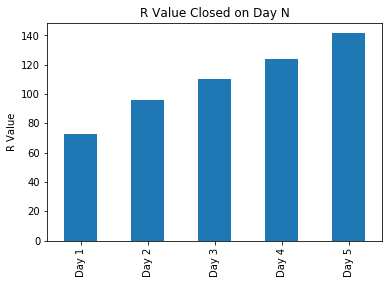

In [20]:
r_df = fill_R(clean_df, r_df, 'day', 0)
print(r_df[['Day 1','Day 2', 'Day 3', 'Day 4', 'Day 5']].sum())
print(" ")
r_df[['Day 1','Day 2', 'Day 3', 'Day 4', 'Day 5']].sum().plot.bar()
plt.ylabel("R Value")
plt.title("R Value Closed on Day N")

### Hit Rate and Expectancy with Above Scenarios

Day  1
Hit Rate of  0.4948717948717949
Expectancy of  -2017.2381974358934

Day  2
Hit Rate of  0.5076923076923077
Expectancy of  -2718.267473076924

Day  3
Hit Rate of  0.517948717948718
Expectancy of  -2995.1858589743592

Day  4
Hit Rate of  0.48205128205128206
Expectancy of  -3091.7692410256423

Day  5
Hit Rate of  0.4846153846153846
Expectancy of  -2435.074129487177



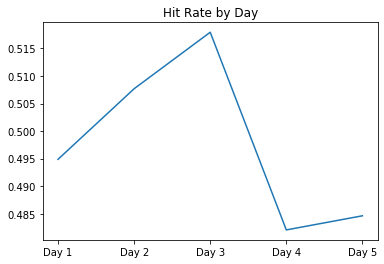

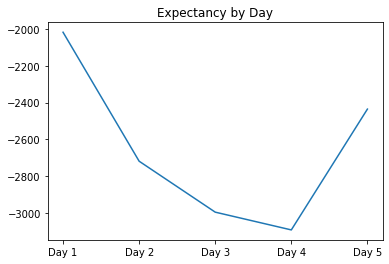

In [21]:
day = ['Day 1', 'Day 2', 'Day 3', 'Day 4', 'Day 5']
hit_rate_array = []
expectancy_array = []
for i in range(len(r_df.columns)-1):
    Hit_rate = calculate_hit(r_df,i)
    hit_rate_array.append(Hit_rate)
    Expectancy = calculate_exp(r_df,i)
    expectancy_array.append(Expectancy)
    print("Day ",i+1)
    print("Hit Rate of ", Hit_rate)
    print("Expectancy of ", Expectancy)
    print("")
    
plt.plot(day, hit_rate_array)
plt.title('Hit Rate by Day')
plt.show()
plt.plot(day, expectancy_array)
plt.title('Expectancy by Day')
plt.show()

### Matrix of ATR vs Holding Period: R, Hit Rate, Expectancy

In [22]:
ATR_r_df = initialize_r(clean_df)
for i in range(len(matrix_r)):
    ATR_r_df = fill_R(clean_df, ATR_r_df, 'ATR', i+1)
    for j in range(len(matrix_r.columns)):
        matrix_r.iat[i,j] = ATR_r_df['Day '+ str(j+1)].sum()  
        matrix_hit_rate.iat[i,j] = calculate_hit(ATR_r_df, j)
        matrix_expectancy.iat[i,j] = calculate_exp(ATR_r_df,j)
        
print("matrix_r")
print(matrix_r)
print(" ")
print("matrix_hit_rate")
print(matrix_hit_rate)
print(" ")
print("matrix_expectancy")
print(" ")
print(matrix_expectancy)

matrix_r
         Day 1    Day 2    Day 3    Day 4    Day 5
ATR 1  245.156  325.556  364.624  399.696  427.737
ATR 2    90.56  121.589  139.296  152.948  166.253
ATR 3  44.6185  64.5661  69.4751  81.8785  88.4641
 
matrix_hit_rate
          Day 1     Day 2     Day 3     Day 4     Day 5
ATR 1  0.494872  0.507692  0.505128  0.471795  0.464103
ATR 2  0.494872  0.507692  0.517949  0.479487  0.484615
ATR 3  0.494872  0.507692  0.517949  0.482051  0.487179
 
matrix_expectancy
 
         Day 1    Day 2    Day 3    Day 4    Day 5
ATR 1 -2813.05 -2108.22 -1433.56  -1363.6 -141.902
ATR 2  -2193.9 -2715.85  -3142.2 -3186.03 -2733.36
ATR 3 -1604.61  -2069.3 -2587.03 -2940.21 -2902.43


## Further Analysis on Loss Trades

* Wanted to see if there was a great Market Influce during loss trades.
* Market Influence meaning that idiosyncratic movement was overpowered by the general index movement.
* Analysis is based on London Exchange where the most loss was generated.
* Main point is to seek a method to hedge away some of the risks.

In [156]:
LSE_df = PnL[PnL['Market'] == 'London'].reset_index(drop = True)
LSE_df.loc[:,'Exchange'] = 'LSE'
LSE_df.loc[:,'Index Performance (%)'] = 0.00
LSE_df.loc[:,'Index Performance (Up/Down)'] = 'Down'
LSE_df.loc[:,'Trade Performance (Up/Down)'] = 'Loss'

In [157]:
Earliest = str(sorted(PnL['Entry Date'])[0])[:10]
Latest = str(sorted(PnL['Exit Date'])[len(PnL)-1])[:10]
LSE_data = fdr.DataReader('UK100', Earliest, Latest).reset_index()

In [158]:
LSE_data

,Date,Close,Open,High,Low,Volume,Change
0,2020-11-05,5906.18,5883.26,5933.05,5881.87,9.000000e+08,0.0039
1,2020-11-06,5910.02,5906.18,5950.22,5858.48,8.484800e+08,0.0007
2,2020-11-09,6186.29,5910.02,6258.31,5910.02,2.070000e+09,0.0467
3,2020-11-10,6296.85,6186.29,6307.00,6180.47,1.710000e+09,0.0179
4,2020-11-11,6382.10,6296.85,6397.28,6293.21,1.280000e+09,0.0135
...,...,...,...,...,...,...,...
73,2021-02-19,6624.02,6617.15,6646.16,6600.59,9.639200e+08,0.0010
74,2021-02-22,6612.24,6624.02,6624.71,6545.93,8.463500e+08,-0.0018
75,2021-02-23,6625.94,6612.24,6675.42,6555.88,1.150000e+09,0.0021
76,2021-02-24,6658.97,6625.94,6669.86,6572.28,1.140000e+09,0.0050


In [166]:
# When You Long but it falls down due to market fall
for i in range(len(LSE_df)):
    entry_date_uk = LSE_df.iloc[i, LSE_df.columns.get_loc('Entry Date')]
    exit_date_uk = LSE_df.iloc[i, LSE_df.columns.get_loc('Exit Date')]
    LSE_open_date = LSE_data[LSE_data['Date'] == entry_date_uk].index[0]
    LSE_close_date  = LSE_data[LSE_data['Date'] == exit_date_uk].index[0]
    LSE_open_price = LSE_data.iloc[LSE_open_date, LSE_data.columns.get_loc('Open')]
    LSE_close_price = LSE_data.iloc[LSE_close_date, LSE_data.columns.get_loc('Close')]
    index_performance = 100 * (LSE_close_price - LSE_open_price) / LSE_open_price 
    LSE_df.iat[i, LSE_df.columns.get_loc('Index Performance (%)')] =  index_performance
    if (index_performance > 0 ):
        LSE_df.iat[i, LSE_df.columns.get_loc('Index Performance (Up/Down)')] = 'Up'

for i in range(len(LSE_df)):
    if (LSE_df['Realized gains'][i] > 0 ):
        LSE_df.iat[i, USA_df.columns.get_loc('Trade Performance (Up/Down)')] = 'Profit'
    
LSE_df = LSE_df.round({'Index Performance (%)':5})
LSE_df.groupby(['Side','Index Performance (Up/Down)','Trade Performance (Up/Down)'])['Ticker'].count()

Side   Index Performance (Up/Down)  Trade Performance (Up/Down)
long   Down                         Loss                           8
                                    Profit                         2
       Up                           Loss                           1
                                    Profit                         1
short  Down                         Loss                           1
                                    Profit                         1
       Up                           Loss                           1
Name: Ticker, dtype: int64

### Potential Hedging Strategy
* Trade Performance is quite indifferent to Index Performance except for when you long while Index is dropping.
* This, with great caution, may be translated as that those long strategies may have higher beta risk on the downside.
* Hence, idiosyncratic event movement is overpowered by the index dropping.
* This risk may be hedged away by shorting the index.
* However, I have too little of data to make a conclusion; with further research I may be able to conclude.